In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as ss
import pickle
strDataDir = 'data'  # where data lives
numExperiments = 100  # number of experiments

In [2]:
def plotBranchModel(B, pt, Y, ttestl, mul, varl, Phi, figsizeIn=(5, 5), lw=3., fs=10, labels=None,
                    fPlotPhi=True, fPlotVar=False, ax=None):
    ''' Plotting code that does not require access to the model but takes as input predictions. '''
    if(ax is None):
        fig = plt.figure(figsize=figsizeIn)
        ax = fig.gca()
    else:
        fig = plt.gcf()
    d = 0  # constraint code to be 1D for now
    for f in range(3):
        mu = mul[f]
        var = varl[f]
        ttest = ttestl[f]
        mean, = ax.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        if(fPlotVar):
            ax.plot(ttest.flatten(), mu[:, d] + 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
            ax.plot(ttest, mu[:, d] - 2 * np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
    v = ax.axis()
    ax.plot([B, B], v[-2:], '-m', linewidth=lw)
    # Plot Phi or labels
    if(fPlotPhi):
        gp_num = 1  # can be 0,1,2 - Plot against this
        PhiColor = ax.scatter(pt, Y[:, d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        plt.colorbar(PhiColor, label='GP {} assignment probability'.format(gp_num))
    return fig

In [3]:
def GetRunData(fSparse, nrun, nTrueB, fPrint=True):
    assert nTrueB >=0 and nTrueB <=3, 'Should be 0 to 3'
    rallDescr = ['Full', 'Sparse']
    fullNamel = ['%s/runArrayJob_%s' % (strDataDir, rallDescr[0]),
                 '%s/runArrayJob_%s' % (strDataDir, rallDescr[1])]
    strfile = fullNamel[fSparse]+str(nrun)+'.p'
    if(fPrint):
        print('Open files %s' % strfile)
    r = pickle.load(open(strfile, "rb"))
    # Get objective functions and GP fits
    BgridSearch = r['BgridSearch']
    Btry = r['Btry']
    Btry[-1] = 1  # integrate GP as 1
    obj = r['mlist'][nTrueB]['obj']
    gridSearchData = r['mlist'][nTrueB]
    gridSearchGPs = r['mlist'][nTrueB]['mlocallist']
    assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
    iMin = np.argmin(obj)  # we could also plot other GPs on the grid
    gpPlot = gridSearchGPs[iMin]  
    return obj, gridSearchData, gridSearchGPs, BgridSearch, Btry 

In [4]:
def GetPosteriorB(fSparse, fPrint=False):
    '''
    Return posterior on B for each experiment
    '''
    _, _, _, BgridSearch, Btry = GetRunData(fSparse, 1, 0, False)  # Get Bgrid and Btry. Experiments is 1-based
    posteriorB = np.zeros((numExperiments, len(Btry), len(BgridSearch))) # nexp X trueB X B grid src
    posteriorB[:] = np.nan    
    for ns in range(1, numExperiments+1):        
        for ib, b in enumerate(Btry):
            obj, gridSearchData, gridSearchGPs, BgridSearchI, BtryI = GetRunData(fSparse, ns, ib, False)
            assert set(BtryI) == set(Btry), 'Btry ust be the same or we are loading wrong file.'
            assert set(BgridSearchI) == set(BgridSearch), 'BgridSearch must be the same or we are loading wrong file.'
            # for each trueB calculate posterior over grid
            # ... in a numerically stable way
            o = -obj
            pn = np.exp(o - np.max(o))
            p = pn/pn.sum()
            assert np.any(~np.isnan(p)), 'Nans in p! %s' % str(p)
            assert np.any(~np.isinf(p)), 'Infinities in p! %s' % str(p)
            posteriorB[ns-1, ib, :] = p
            if(fPrint):
                print('%g:B=%s probs=' % (ns, b), np.round(p, 2))
    return posteriorB, Btry, BgridSearch
posteriorBFull, Btry, BgridSearch = GetPosteriorB(False, False)
posteriorBSparse, Btry, BgridSearch = GetPosteriorB(True, False)

In [5]:
def GetMeanRank(posteriorB, Btry, BgridSearch):
    '''
    Return mean rank for synthetic experiment
    '''
    numExps = posteriorB.shape[0]
    assert numExps == numExperiments
    numTrueB = posteriorB.shape[1]
    assert numTrueB == len(Btry)
    numGrid = posteriorB.shape[2]
    assert numGrid == len(BgridSearch)
    # for each experiment
    meanRank = np.zeros((numExps, numTrueB))  # nexp X num true B
    meanRank[:] = np.nan
    nMC = 100  # do Monte Carlo estimation of rank
    ranks = np.zeros((numExps, nMC, numTrueB))  # rank
    ranks[:] = np.nan
    samples = np.zeros((numExps, nMC, numTrueB))  # samples from Branching posterior
    samples[:] = np.nan
    for ns in range(numExps):
        for m in range(nMC):
            for ib, b in enumerate(Btry):
                # Sample from posterior for given branch pt
                samples[ns, m, ib] = np.random.choice(BgridSearch, p=posteriorB[ns, ib, :])
            # Rank each branch point
            ranks[ns, m, :] = ss.rankdata(samples[ns, m, :])  # only calculate rank if no errors
        # Calculate mean rank
        meanRank[ns, :] = np.mean(ranks[ns, :, :], 0)
        assert np.all(~np.isnan(meanRank[ns, :]))
    return meanRank, ranks, samples
meanRankFull, ranksFull, samplesFull = GetMeanRank(posteriorBFull, Btry, BgridSearch)
meanRankSparse, ranksSparse, samplesSparse = GetMeanRank(posteriorBSparse, Btry, BgridSearch)

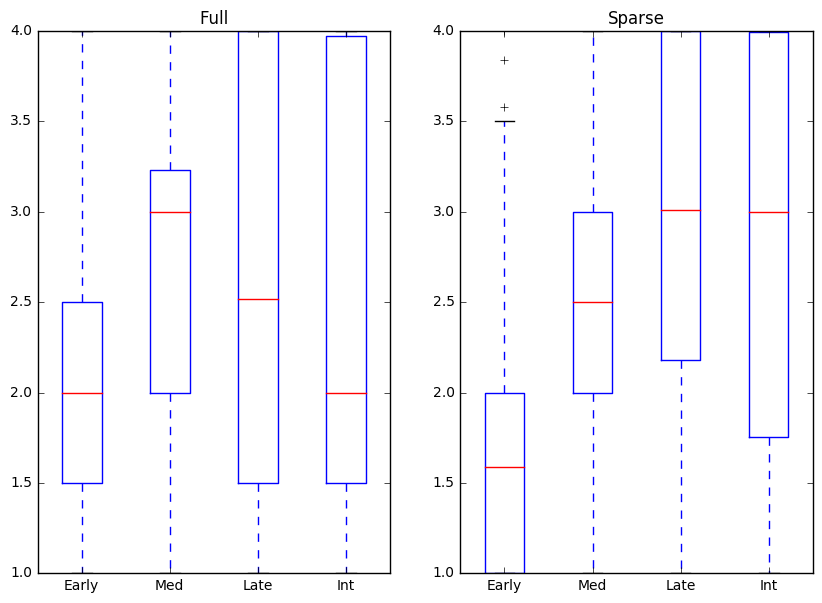

In [6]:
f, axarr = plt.subplots(1, 2, figsize=(10, 7))
ax = axarr.flatten()
ax[0].boxplot(meanRankFull, labels=['Early', 'Med', 'Late', 'Int'])
ax[0].set_title('Full')
ax[1].boxplot(meanRankSparse, labels=['Early', 'Med', 'Late', 'Int'])
ax[1].set_title('Sparse')

Open files data/runArrayJob_Full98.p
Mean rank
 [ 1.525  1.525  2.95   4.   ] 
posterior
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


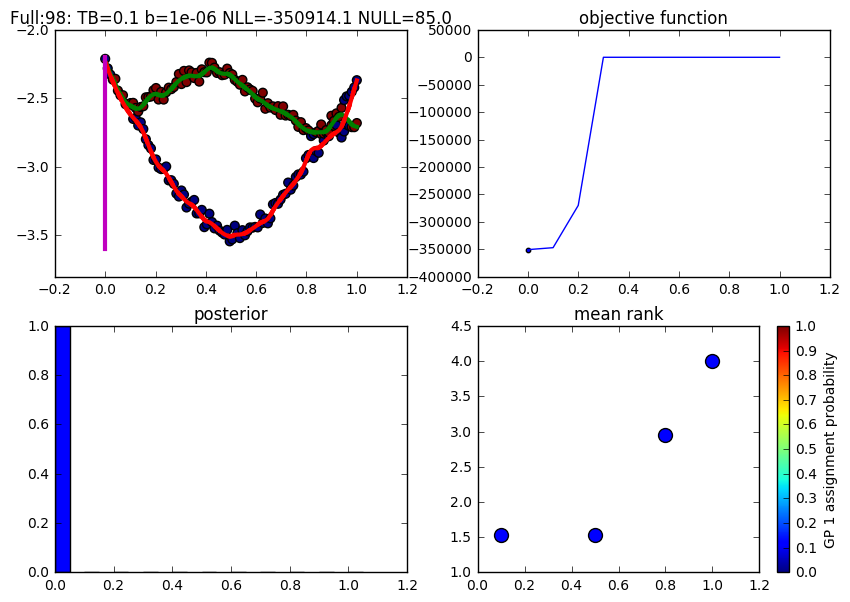

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
    
def plotBranchingModel(fSparse = False, nrun = 98, nTrueB = 0):
    rallDescr = ['Full', 'Sparse']
    if(fSparse):
        rank = meanRankSparse
        posteriorB = posteriorBSparse
    else:
        rank = meanRankFull
        posteriorB = posteriorBFull
    obj, gridSearchData, gridSearchGPs, BgridSearch, Btry = GetRunData(fSparse, nrun, nTrueB)
    assert len(obj) == len(gridSearchGPs), 'One GP per grid search pt'
    iMin = np.argmin(obj)  # we could also plot other GPs on the grid
    gpPlot = gridSearchGPs[iMin]    
    # Plot GP
    f, axarr = plt.subplots(2, 2, figsize=(10, 7))
    ax = axarr.flatten()
    _=plotBranchModel(gpPlot['candidateB'], gridSearchData['pt'], gridSearchData['Y'],
                      gpPlot['ttestl'], gpPlot['mul'], gpPlot['varl'],
                      gpPlot['Phi'], fPlotPhi=True, fPlotVar=True, ax=ax[0])
    ax[0].set_title('%s:%g: TB=%s b=%g NLL=%.1f NULL=%.1f' % (rallDescr[fSparse], nrun,
                                                        gridSearchData['trueBStr'],
                                                        gpPlot['candidateB'],
                                                        gpPlot['obj'],
                                                        gridSearchData['objInt']))
    ax[1].set_title('objective function')
    ax[1].plot(BgridSearch, obj, '-b')
    ax[1].scatter(BgridSearch[iMin], obj[iMin], s=10)
    ax[2].bar(BgridSearch, posteriorB[nrun-1, nTrueB, :], 0.05)  # experiments are 1-based
    ax[2].set_title('posterior')
    ax[3].scatter(Btry, rank[nrun-1, :], s=100)  # experiments are 1-based
    ax[3].set_title('mean rank')
    print('Mean rank\n', rank[nrun-1, :], '\nposterior\n',  np.round(posteriorB[nrun-1, nTrueB, :], 2))

_=interact(plotBranchingModel, fSparse=False, nrun=(1, 100), nTrueB=(0, 3))